# Customer Segmentation 

In [361]:
import pandas as pd
import warnings
import sqlite3
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from matplotlib import pyplot as plt
pio.templates.default = "plotly_white"
warnings.filterwarnings("ignore")

pd.set_option("display.max_columns",100)
pd.set_option("display.max_rows",100)

### Importing Data

In [362]:
df = pd.read_csv("PBL5recommendationdata.csv", encoding="latin-1")

In [363]:
df.head()

,Customers.id,Customers.fname,Customers.lname,Customers.company,Customers.create_date,Customers.status,Customers.mailing,Customers.reminders,Customers.tax_exempt,Customers.account_id,Customers.sales_rep,Customers.rewards,Customers.profile_id,Customers.last_modified,Customers.customer_type,Orders.id,Orders.customer_id,Orders.fname,Orders.lname,Orders.company,Orders.order_number,Orders.reorder_id,Orders.external_source,Orders.external_id,Orders.currency,Orders.sales_rep,Orders.subtotal,Orders.tax,Orders.shipping,Orders.coupon_id,Orders.coupon_amount,Orders.gift_id,Orders.gift_amount,Orders.fee_name,Orders.fee_amount,Orders.discount_name,Orders.discount_amount,Orders.total,Orders.balance_due,Orders.shipping_carrier,Orders.shipping_method,Orders.shipping_trans,Orders.shipping_flags,Orders.weight,Orders.tracking,Orders.payment_status,Orders.payment_date,Orders.payment_user,Orders.payment_type,Orders.payment_method,...,Products.seo_description,Products.seo_keywords,Products.seo_header,Products.seo_footer,Products.seo_url,Products.seo_category,Products.unit,Products.packaging,Products.display_packaging,Products.multiple,Products.length,Products.width,Products.height,Products.rx,Products.latex,Products.upc,Products.msds_link,Products.msds_label,Products.lit_link,Products.lit_label,Products.hcpcs,Products.case_qty,Products.markup,Products.override_markup,Products.notes,Products.import_flags,Products.map_price,Products.features_title,Products.warranty,Products.hygienic,Products.default_quantity,Products.user_size,Products.assembly,Products.installation,Products.shipping_length,Products.shipping_width,Products.shipping_height,Products.shipping_weight,Products.handling_time,Products.rotation_link,Products.google_shopping_label,Products.product_option,Products.size,Products.material,Products.arm_style,Products.leg_style,Products.seat_size,Products.family_id,Products.saved_status,Products.freight_cost
0,797,Christy,Dill,Company0,1426018724,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1437764306,0.0,3758,797,Christy,Dill,Company0,3758,NaN,NaN,NaN,USD,NaN,57.20,0.0,9.95,13.0,2.86,NaN,NaN,NaN,NaN,NaN,NaN,64.29,NaN,fedex,11|Ground,NaN,NaN,NaN,5.7204E+14,3.0,1.426019e+09,NaN,authorize.net,NaN,...,NaN,NaN,NaN,NaN,Basic-Rollators-For-Adults-With-Seat-Green-6-W...,0.0,EA,1 Each / Each,NaN,1 EA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,E0149 +E0156,1.0,NaN,0.0,NaN,136.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,24.80,7.50,30.40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PF61071,0.0,NaN
1,3,John,Smith,Company1,1386089139,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1437764354,0.0,23,3,John,Smith,Company1,23,NaN,NaN,NaN,USD,NaN,20.00,NaN,9.99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.99,NaN,fedex,11|Ground,NaN,NaN,NaN,1.28597E+14,3.0,1.386090e+09,NaN,authorize.net,NaN,...,NaN,NaN,NaN,NaN,Urinary-Drain-Bags0000,0.0,EA,1 Each / Each,NaN,1 EA,NaN,NaN,NaN,Rx,Yes,NaN,NaN,NaN,https://medline360.medline.com:443/irj/servlet...,508f2d75-582e-2e10-2eab-d83980a9b1d0,A4357,1.0,NaN,0.0,OFF sale cause it is an RX item,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,8.00,7.00,1.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PF02132,NaN,NaN
2,3,John,Smith,Company1,1386089139,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1437764354,0.0,9531,3,John,Smith,Company1,9531,NaN,NaN,NaN,USD,NaN,68.78,0.0,9.95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,78.73,NaN,manual,0|Standard Shipping,NaN,NaN,NaN,NaN,3.0,1.449604e+09,genlee166,authorize.net,NaN,...,NaN,NaN,NaN,NaN,SensiCare-Nitrile-Exam-GlovesBlueXX-Large,0.0,CS,800 Each / Case,NaN,1 CS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO GOVERNMENT OR SUPPLIER HCPCS CODE VERIFICATION,800.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.23,10.04,10.24,NaN,NaN,NaN,NaN,NaN,2 x Extra large,Nitrile,NaN,NaN,NaN,PF00342,0.0,NaN
3,4,James,Anderson,NaN,1386780263,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1437762646,0.0,29,4,James,Anderson,NaN,29,NaN,Ebay,NaN,USD,NaN,19.56,0.0,9.95,NaN,NaN,NaN,NaN,NaN,0.04,NaN,NaN,29.55,NaN,NaN,11|Ground,NaN,NaN,NaN,7.96468E+14,3.0,1.386780e+09,NaN,NaN,Credit Card,...,NaN,NaN,NaN,NaN,Basket-for-2-Butt

## Basic Feature Engineering Before saving DB

In [364]:
df['Customers.customer_type'].value_counts()

Customers.customer_type
0.0    3319
1.0     386
2.0      66
Name: count, dtype: int64

In [365]:
# fill null Customers.customer_type  with mode
df['Customers.customer_type'].fillna(df['Customers.customer_type'].mode()[0], inplace=True)
df['Customers.customer_type'] = df['Customers.customer_type'].astype('int64')
 

In [366]:
df.columns

Index(['Customers.id', 'Customers.fname', 'Customers.lname',
       'Customers.company', 'Customers.create_date', 'Customers.status',
       'Customers.mailing', 'Customers.reminders', 'Customers.tax_exempt',
       'Customers.account_id',
       ...
       'Products.google_shopping_label', 'Products.product_option',
       'Products.size', 'Products.material', 'Products.arm_style',
       'Products.leg_style', 'Products.seat_size', 'Products.family_id',
       'Products.saved_status', 'Products.freight_cost'],
      dtype='object', length=181)

In [367]:
df = df.dropna(subset=['Products.id'])
df = df.dropna(subset=['Orders.placed_date'])
df = df.dropna(subset=['Orders.payment_status'])

In [368]:
df['Orders.placed_date'] = pd.to_datetime(df['Orders.placed_date'], unit='s')
df['Orders.placed_date'] = df['Orders.placed_date'].dt.date

In [369]:
df['Products.id']

0       2310.0
1        177.0
2          1.0
3        983.0
4        991.0
         ...  
4189    1842.0
4190     782.0
4191    2707.0
4192     993.0
4193     562.0
Name: Products.id, Length: 4032, dtype: float64

### Saving the data to a sqlite database

In [370]:
customers_columns = [col for col in df.columns if col.startswith('Customers')]
orders_columns = [col for col in df.columns if col.startswith('Orders') or col.startswith('Order_Items')]
products_columns = [col for col in df.columns if col.startswith('Products')]

In [371]:
customers_df = df[customers_columns]
orders_df = df[orders_columns]
products_df = df[products_columns]

In [372]:

customers_df.columns = customers_df.columns.str.replace('^Customers\.', '', regex=True)
orders_df.columns = orders_df.columns.str.replace('^Orders\.', '', regex=True)
orders_df.columns = orders_df.columns.str.replace('^Order_Items\.', 'item_', regex=True)
products_df.columns = products_df.columns.str.replace('^Products\.', '', regex=True)

In [373]:
orders_df.head()

,id,customer_id,fname,lname,company,order_number,reorder_id,external_source,external_id,currency,sales_rep,subtotal,tax,shipping,coupon_id,coupon_amount,gift_id,gift_amount,fee_name,fee_amount,discount_name,discount_amount,total,balance_due,shipping_carrier,shipping_method,shipping_trans,shipping_flags,weight,tracking,payment_status,payment_date,payment_user,payment_type,payment_method,payment_amount,purchase_order,payment_id,payment_code,payment_ref,status,placed_date,updated_date,shipped_date,comments,notes,registry_id,gift_message,website,mailing,flags,partial_ship,customer_type,item_id,item_parent,item_product_id,item_product_name,item_attributes,item_attribute_names,item_attribute_prices,item_qty,item_price,item_cost,item_registry_item,item_related_id,item_reorder_frequency,item_account_id,item_flags
0,3758,797,Christy,Dill,Company0,3758,NaN,NaN,NaN,USD,NaN,57.20,0.0,9.95,13.0,2.86,NaN,NaN,NaN,NaN,NaN,NaN,64.29,NaN,fedex,11|Ground,NaN,NaN,NaN,5.7204E+14,3.0,1.426019e+09,NaN,authorize.net,NaN,64.29,NaN,6993607863,510142,NaN,1,2015-03-10,1.438868e+09,1.426101e+09,NaN,Insured By Eye4Fraud,NaN,NaN,NaN,NaN,NaN,NaN,0.0,5284,3758,2310.0,"Basic Rollators, Green",NaN,NaN,NaN,1,57.20,44.00,NaN,NaN,NaN,NaN,NaN
1,23,3,John,Smith,Company1,23,NaN,NaN,NaN,USD,NaN,20.00,NaN,9.99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.99,NaN,fedex,11|Ground,NaN,NaN,NaN,1.28597E+14,3.0,1.386090e+09,NaN,authorize.net,NaN,29.99,NaN,0,0,NaN,1,2013-12-03,1.440529e+09,1.386103e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,31,23,177.0,"Urinary Drain Bags,0.000",NaN,NaN,NaN,4,5.00,1.87,NaN,NaN,NaN,NaN,2.0
2,9531,3,John,Smith,Company1,9531,NaN,NaN,NaN,USD,NaN,68.78,0.0,9.95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,78.73,NaN,manual,0|Standard Shipping,NaN,NaN,NaN,NaN,3.0,1.449604e+09,genlee166,authorize.net,NaN,78.73,NaN,0,0,NaN,3,2015-12-08,1.450213e+09,NaN,test order,Test,NaN,NaN,NaN,NaN,NaN,NaN,0.0,11655,9531,1.0,"SensiCare Nitrile Exam Gloves, Blue, XX-Large",NaN,NaN,NaN,1,68.78,52.50,NaN,NaN,NaN,NaN,NaN
3,29,4,James,Anderson,NaN,29,NaN,Ebay,NaN,USD,NaN,19.56,0.0,9.95,NaN,NaN,NaN,NaN,NaN,0.04,NaN,NaN,29.55,NaN,NaN,11|Ground,NaN,NaN,NaN,7.96468E+14,3.0,1.386780e+09,NaN,NaN,Credit Card,29.55,NaN,NaN,NaN,NaN,1,2013-12-11,1.440529e+09,1.386800e+09,ebay order\rpaid by pay pal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1816,29,983.0,Basket for 2-Button Walkers,NaN,NaN,NaN,1,19.56,12.62,NaN,NaN,NaN,NaN,NaN
4,30,5,Abraham,Pollak,Company3,30,NaN,NaN,NaN,USD,NaN,36.05,NaN,9.95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.00,NaN,fedex,11|Ground,NaN,NaN,NaN,6.87398E+14,3.0,1.386862e+09,NaN,NaN,Credit Card,46.00,NaN,NaN,NaN,NaN,1,2013-12-12,1.440529e+09,1.386876e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,40,30,991.0,Tens Units,NaN,NaN,NaN,1,36.05,25.75,NaN,NaN,NaN,NaN,NaN


In [374]:
orders_df.shipped_date.isnull().sum()   

333

In [375]:
orders_df.columns

Index(['id', 'customer_id', 'fname', 'lname', 'company', 'order_number',
       'reorder_id', 'external_source', 'external_id', 'currency', 'sales_rep',
       'subtotal', 'tax', 'shipping', 'coupon_id', 'coupon_amount', 'gift_id',
       'gift_amount', 'fee_name', 'fee_amount', 'discount_name',
       'discount_amount', 'total', 'balance_due', 'shipping_carrier',
       'shipping_method', 'shipping_trans', 'shipping_flags', 'weight',
       'tracking', 'payment_status', 'payment_date', 'payment_user',
       'payment_type', 'payment_method', 'payment_amount', 'purchase_order',
       'payment_id', 'payment_code', 'payment_ref', 'status', 'placed_date',
       'updated_date', 'shipped_date', 'comments', 'notes', 'registry_id',
       'gift_message', 'website', 'mailing', 'flags', 'partial_ship',
       'customer_type', 'item_id', 'item_parent', 'item_product_id',
       'item_product_name', 'item_attributes', 'item_attribute_names',
       'item_attribute_prices', 'item_qty', 'item_pri

In [376]:
conn = sqlite3.connect('example.db')

customers_df.to_sql('customers', conn, if_exists='replace', index=False)
orders_df.to_sql('orders', conn, if_exists='replace', index=False)
products_df.to_sql('products', conn, if_exists='replace', index=False)

conn.close()

### Importing data from sqlite

In [377]:
conn = sqlite3.connect('example.db')

query = """
        SELECT  customers.id AS CustomerID,
                customers.customer_type AS CustomerType,
                orders.id AS OrderID,
                orders.placed_date AS Date,
                orders.total AS Total,
                orders.item_qty AS Quantity,
                orders.item_price AS Price,
                orders.payment_status AS PaymentStatus,
                products.id AS ProductID
              
        FROM customers
        JOIN orders ON customers.id = orders.customer_id
        JOIN products ON orders.item_product_id = products.id
        """
df = pd.read_sql_query(query, conn)

conn.close()


In [378]:
df['ProductID'] = df['ProductID'].astype('int64')
df['PaymentStatus'] = df['PaymentStatus'].astype('int64')

In [379]:
df['Date'] = pd.to_datetime(df['Date'])

In [380]:
df.head()

,CustomerID,CustomerType,OrderID,Date,Total,Quantity,Price,PaymentStatus,ProductID
0,797,0,3758,2015-03-10,64.29,1,57.20,3,2310
1,797,0,3758,2015-03-10,64.29,1,57.20,3,2310
2,3,0,23,2013-12-03,29.99,4,5.00,3,177
3,3,0,9531,2015-12-08,78.73,1,68.78,3,1
4,3,0,23,2013-12-03,29.99,4,5.00,3,177


## RFM Table

In [381]:
from datetime import datetime

df['Recency'] = (datetime.now().date() - df['Date'].dt.date)

frequency_data = df.groupby('CustomerID')['OrderID'].count().reset_index()
frequency_data.rename(columns={'OrderID': 'Frequency'}, inplace=True)
df = df.merge(frequency_data, on='CustomerID', how='left')

monetary_data = df.groupby('CustomerID')['Total'].sum().reset_index()
monetary_data.rename(columns={'Total': 'MonetaryValue'}, inplace=True)
df = df.merge(monetary_data, on='CustomerID', how='left')

In [382]:
df['Recency'] = df['Recency'].astype(str)
df['Recency'] = df['Recency'].str.extract('(\d+)').astype(int)

In [383]:
recency_scores = [5, 4, 3, 2, 1]  
frequency_scores = [1, 2, 3, 4, 5]  
monetary_scores = [1, 2, 3, 4, 5] 
df['RecencyScore'] = pd.cut(df['Recency'], bins=5, labels=recency_scores)
df['FrequencyScore'] = pd.cut(df['Frequency'], bins=5, labels=frequency_scores)
df['MonetaryScore'] = pd.cut(df['MonetaryValue'], bins=5, labels=monetary_scores)

In [384]:
df['RecencyScore'] = df['RecencyScore'].astype(int)
df['FrequencyScore'] = df['FrequencyScore'].astype(int)
df['MonetaryScore'] = df['MonetaryScore'].astype(int)

In [385]:
df['RFM_Score'] = df['RecencyScore'] + df['FrequencyScore'] + df['MonetaryScore']

In [386]:
df.head()

,CustomerID,CustomerType,OrderID,Date,Total,Quantity,Price,PaymentStatus,ProductID,Recency,Frequency,MonetaryValue,RecencyScore,FrequencyScore,MonetaryScore,RFM_Score
0,797,0,3758,2015-03-10,64.29,1,57.20,3,2310,3417,2,128.58,3,1,1,5
1,797,0,3758,2015-03-10,64.29,1,57.20,3,2310,3417,2,128.58,3,1,1,5
2,3,0,23,2013-12-03,29.99,4,5.00,3,177,3879,4,217.44,1,1,1,3
3,3,0,9531,2015-12-08,78.73,1,68.78,3,1,3144,4,217.44,5,1,1,7
4,3,0,23,2013-12-03,29.99,4,5.00,3,177,3879,4,217.44,1,1,1,3


In [387]:
df.columns

Index(['CustomerID', 'CustomerType', 'OrderID', 'Date', 'Total', 'Quantity',
       'Price', 'PaymentStatus', 'ProductID', 'Recency', 'Frequency',
       'MonetaryValue', 'RecencyScore', 'FrequencyScore', 'MonetaryScore',
       'RFM_Score'],
      dtype='object')

### Model Building and RFM Analysis

In [388]:
x = df[['Recency', 'Frequency', 'MonetaryValue', 'RecencyScore', 'FrequencyScore', 'MonetaryScore', 'RFM_Score']]

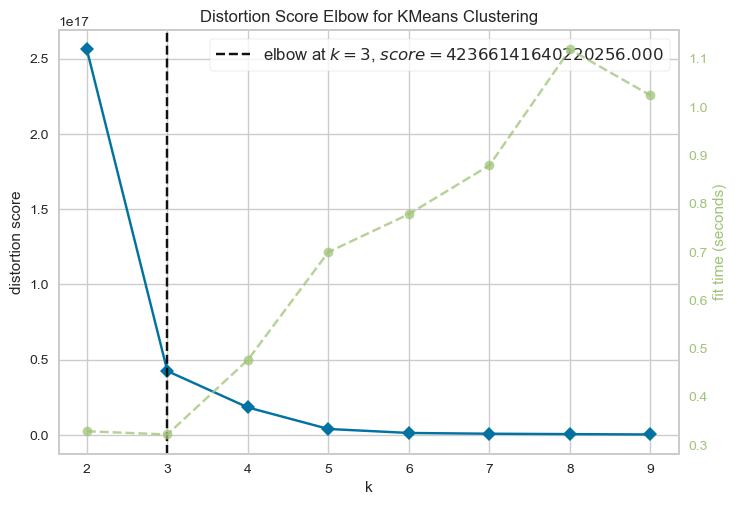

In [389]:
km = KMeans()
vis = KElbowVisualizer(km, k=(2, 10))
vis.fit(x)
vis.show();

In [390]:
model = KMeans(n_clusters=3, random_state=42)

In [391]:
model = model.fit(x)
pred = model.predict(x)

In [392]:
x['Cluster'] = pred

In [393]:
x.sample(20)

,Recency,Frequency,MonetaryValue,RecencyScore,FrequencyScore,MonetaryScore,RFM_Score,Cluster
108970,3160,18690,2706151.35,5,4,2,11,0
37732,3516,52,7003.88,3,1,1,5,2
128780,3233,67,8813.18,4,1,1,6,2
66477,3380,792,21753.60,3,1,1,5,2
113655,3213,18690,2706151.35,4,4,2,10,0
18366,3353,13720,4055788.80,3,3,3,9,0
106047,3000,18690,2706151.35,5,4,2,11,0
153473,3035,118,8599.84,5,1,1,7,2
138326,3138,88,1428.24,5,1,1,7,2
90759,3203,26609,9542478.17,4,5,5,14,1


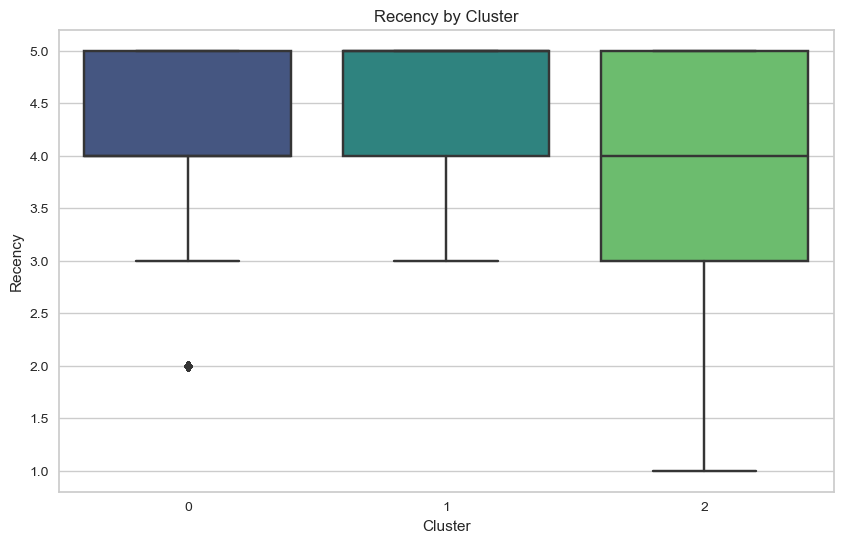

In [394]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster', y='RecencyScore', data=x, palette='viridis')
plt.title('Recency by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Recency')
plt.show()

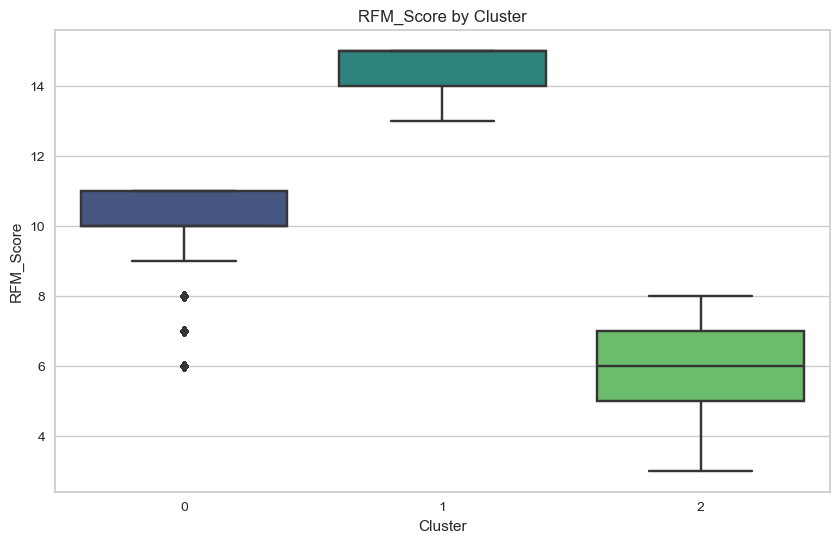

In [395]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster', y='RFM_Score', data=x, palette='viridis')
plt.title('RFM_Score by Cluster')
plt.xlabel('Cluster')
plt.ylabel('RFM_Score'),
plt.show()

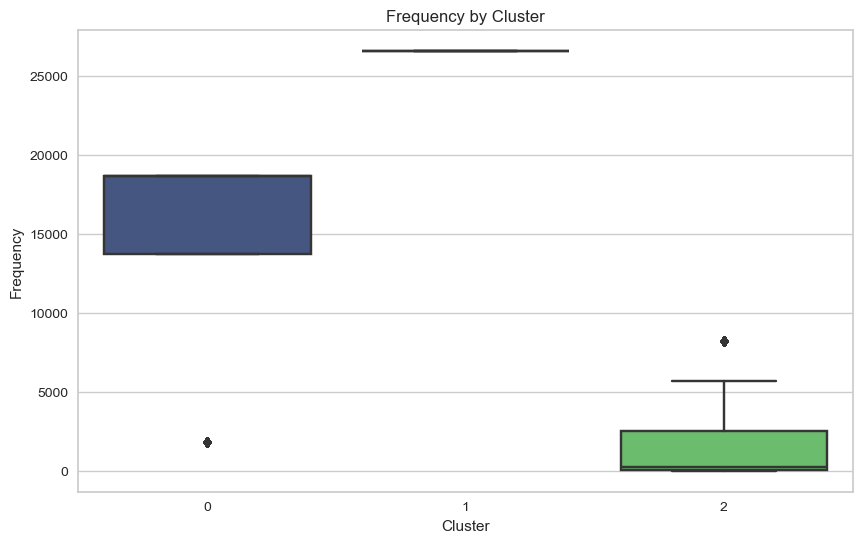

In [396]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster', y='Frequency', data=x, palette='viridis')
plt.title('Frequency by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Frequency'),
plt.show()

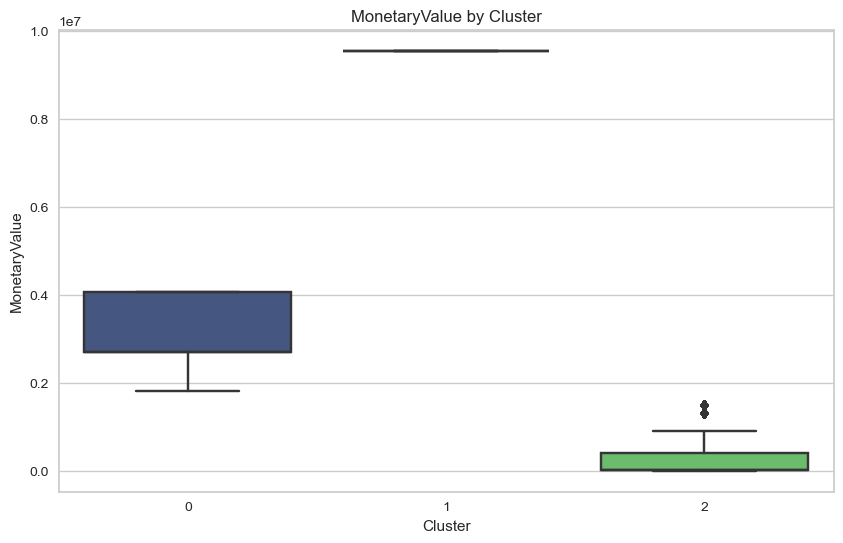

In [397]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster', y='MonetaryValue', data=x, palette='viridis')
plt.title('MonetaryValue by Cluster')
plt.xlabel('Cluster')
plt.ylabel('MonetaryValue'),
plt.show()

<Axes: xlabel='RFM_Score', ylabel='Recency'>

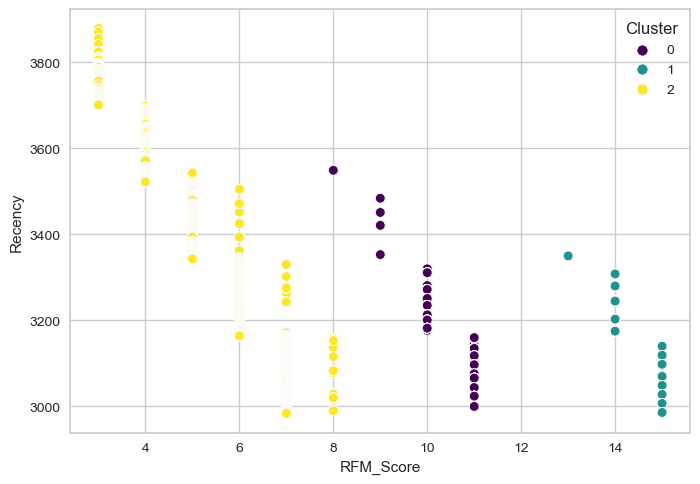

In [398]:
sns.scatterplot(x='RFM_Score', y='Recency', hue='Cluster', data=x, palette='viridis')

<Axes: xlabel='RFM_Score', ylabel='FrequencyScore'>

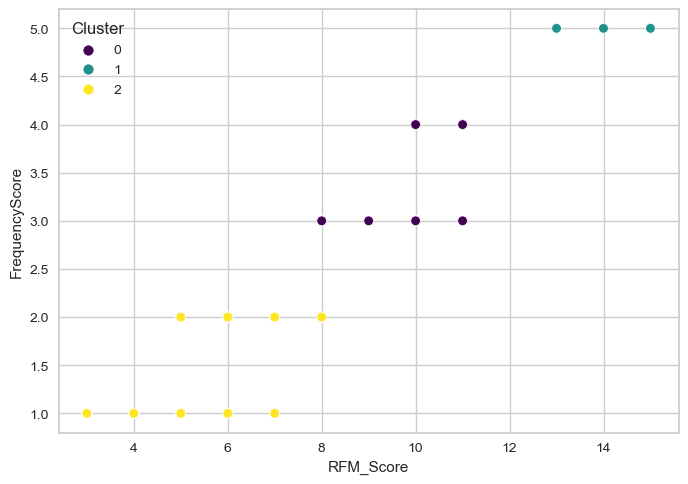

In [399]:
sns.scatterplot(x='RFM_Score', y='FrequencyScore', hue='Cluster', data=x, palette='viridis')

<Axes: xlabel='RFM_Score', ylabel='MonetaryScore'>

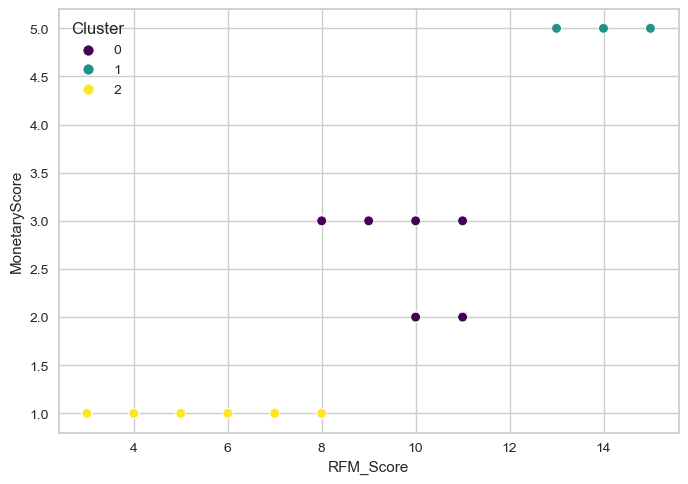

In [400]:
sns.scatterplot(x='RFM_Score', y='MonetaryScore', hue='Cluster', data=x, palette='viridis')

In [401]:
silhouette_score(x, pred)

0.824781732895414

## Conclusion
* In this project, I tried to understand RFM analysis and perform customer grouping.
* I created 3 different clusters using the KMeans algorithm.
* According to the Silhouette score, our model received a good 